In [2]:
############ Set this to either Up or Down ###############
DIRECTION = 'Up'   # 'Up' examines genes DE in Albany
##########################################################

# Analysis parameters
FC_THRESH = 2.0    # fold-change threshold for filtering DE genes
GSEA_THRESH = 0.05 # FDR threshold for enriched gene sets

import os
from os.path import join
import pandas as pd
from collections import defaultdict
import subprocess
import json

# Set the location to various files
with open('config.json', 'r') as f:
    CONFIG = json.load(f)
RAW_DATA_LOC = join(os.getcwd(), '../raw_data') #CONFIG['raw_data_location']
OUT_LOC = join(os.getcwd(), 'results') #CONFIG['output_location']
GENE_SETS = {
    'GO_molecular_function': 'gene_sets/c5.mf.v7.1.symbols.gmt',
    'GO_biological_process': 'gene_sets/c5.bp.v7.1.symbols.gmt',
    'MSigDB_Canonical_Pathways': 'gene_sets/c2.cp.v7.1.symbols.gmt',
    'MSigDB_Hallmark': 'gene_sets/h.all.v7.1.symbols.gmt'
}

# Create the output directory in which to store results
subprocess.run('mkdir -p {}/englert_vs_albany_de/filter_DE_AE_11'.format(OUT_LOC), shell=True)
subprocess.run('mkdir -p {}/englert_vs_albany_de/filter_DE_AE_11/male_only_heatmaps'.format(OUT_LOC), shell=True)

de_genes_f = join(RAW_DATA_LOC, 'Albany_and_Englert/ebseq_males.ARDS.COVID.v.NO_HSCT/{}.Genes.pp99.txt'.format(DIRECTION))
ec_f = join(RAW_DATA_LOC, 'Albany_and_Englert/ebseq_males.ARDS.COVID.v.NO_HSCT/{}.Genes.pp99.Normed.tsv'.format(DIRECTION))
raw_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/genes.tpm.no_hg.no_C054.tab')
eff_len_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/median_effective_length.tsv')
symbol_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/Symbol_ENSG.tsv')

out_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_ICU_COVID_VS_Englart_ARDS_{}_DE_GSEA.DE_AE_11.tsv'.format(DIRECTION))
out_kept_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_ICU_COVID_VS_Englart_ARDS_{}_DE.kept_genes.DE_AE_11.tsv'.format(DIRECTION))
out_venn_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_venn_{}.pdf'.format(DIRECTION))
de_table_f = join(RAW_DATA_LOC, 'de_tables/{}.Genes.pp95.flags.tsv'.format(DIRECTION))
de_table_col = 'DE_AE_11'

Load the DE genes

In [3]:
with open(de_genes_f, 'r') as f:
    de_genes = [l.strip() for l in f]
print("{} total DE genes".format(len(de_genes)))

1487 total DE genes


Load the set of all the genes from the original expression matrix

In [4]:
raw_df = pd.read_csv(raw_f, sep='\t', index_col=0)
all_genes = list(raw_df.index)
print('{} total genes'.format(len(all_genes)))

19462 total genes


Load the gene lengths

In [5]:
len_df = pd.read_csv(eff_len_f, sep='\t', index_col=0, header=None)
len_df = len_df.loc[all_genes]
gene_lens = list(len_df[1])
len_df

,1
0,
A1BG,3177.44
A1CF,8968.44
A2M,4245.44
A2ML1,4259.44
A3GALT2,818.44
...,...
ZYG11A,3488.44
ZYG11B,7938.44
ZYX,2019.96


 Map each gene to its fold change

In [6]:
ec_df = pd.read_csv(ec_f, sep='\t', index_col=0)
gene_to_fc = {
    gene: ec_df.loc[gene]['FC']
    for gene in ec_df.index
}
ec_df

,PP,C008,C010,C012,C014,C015,C020,C021,C022,C023,...,C099,C101,SRR3923733,SRR3923735,SRR3923736,SRR3923737,SRR3923738,SRR3923739,FC,L2FC
symbol,,,,,,,,,,,,,,,,,,,,,
CXCL8,1.00,484,915,1409,4468,6237,1441,1725,1775,10839,...,605,2117,36,89,43,5,187,8,74.27,6.2
FOXH1,1.00,43,11,61,37,65,13,41,25,25,...,249,306,3,0,0,0,1,0,59.56,5.9
ANKS1B,1.00,4,2,1,8,7,0,1,5,3,...,535,52,2,1,4,0,0,0,56.86,5.8
EGR1,1.00,2362,1246,445,147,2458,5346,4839,1434,5226,...,1672,836,69,23,98,39,19,51,38.02,5.2
TBC1D3C,1.00,615,0,0,0,536,0,0,18,9,...,0,312,5,1,0,0,0,9,30.40,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATG10,0.99,115,68,77,104,67,76,103,178,106,...,78,84,90,60,80,59,52,31,1.53,0.6
ABHD17B,0.99,373,292,429,519,412,361,535,488,444,...,213,233,291,269,263,226,209,173,1.51,0.6
C12orf76,0.99,270,296,254,360,532,280,651,442,334,...,584,229,166,223,271,197,223,236,1.50,0.6


Filter genes by fold-change

In [7]:
fold_filtered_genes = [
    gene
    for gene in gene_to_fc
    if gene_to_fc[gene] > FC_THRESH or gene_to_fc[gene] < (1/FC_THRESH)
]
print("{} genes with absolute fold-change > {}".format(
    len(fold_filtered_genes),
    FC_THRESH
))
ec_df.loc[fold_filtered_genes]

926 genes with absolute fold-change > 2.0


,PP,C008,C010,C012,C014,C015,C020,C021,C022,C023,...,C099,C101,SRR3923733,SRR3923735,SRR3923736,SRR3923737,SRR3923738,SRR3923739,FC,L2FC
symbol,,,,,,,,,,,,,,,,,,,,,
CXCL8,1.00,484,915,1409,4468,6237,1441,1725,1775,10839,...,605,2117,36,89,43,5,187,8,74.27,6.2
FOXH1,1.00,43,11,61,37,65,13,41,25,25,...,249,306,3,0,0,0,1,0,59.56,5.9
ANKS1B,1.00,4,2,1,8,7,0,1,5,3,...,535,52,2,1,4,0,0,0,56.86,5.8
EGR1,1.00,2362,1246,445,147,2458,5346,4839,1434,5226,...,1672,836,69,23,98,39,19,51,38.02,5.2
TBC1D3C,1.00,615,0,0,0,536,0,0,18,9,...,0,312,5,1,0,0,0,9,30.40,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STXBP5,0.99,4434,2664,4666,5147,7008,5809,8184,7335,4894,...,1564,794,1545,3027,2936,368,1051,868,2.34,1.2
AICDA,0.99,27,17,20,22,49,58,21,54,15,...,16,12,7,9,12,8,16,6,2.09,1.1
ANKRD50,0.99,491,123,306,399,357,228,387,272,487,...,61,100,131,97,175,41,111,115,2.02,1.0


Load the DE flags table

In [8]:
de_table_df = pd.read_csv(de_table_f, sep='\t', index_col=0)
de_table_df

,DE_A_01,DE_A_02,DE_A_03,DE_A_04,DE_A_05,DE_A_06,DE_A_07,DE_A_08,DE_A_09,DE_E_01,...,DE_AE_04,DE_AE_05,DE_AE_06,DE_AE_07,DE_AE_08,DE_AE_09,DE_AE_10,DE_AE_11,DE_AE_12,DE_AE_13
symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3GALT2,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11B,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,1
ZYX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Select the likely batch effect genes

In [9]:
batch_effect_genes = frozenset(
    de_table_df.loc[de_table_df[de_table_col] == 1].index
)
print('{} total genes considered to be "batch-effect" genes'.format(len(batch_effect_genes)))

1422 total genes considered to be "batch-effect" genes


Remove the batch effect genes

In [10]:
removed_batch_effect_genes = batch_effect_genes & set(fold_filtered_genes)
print('Removed {} genes.'.format(
    len(removed_batch_effect_genes)
))
fold_batch_filtered_genes = sorted(set(fold_filtered_genes) - batch_effect_genes)
print('{}/{} remain after filtering by batch-effect:'.format(
    len(fold_batch_filtered_genes),
    len(gene_to_fc)
))

Removed 490 genes.
436/1487 remain after filtering by batch-effect:


Plot the Venn diagram

In [11]:
import matplotlib as mpl
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
if 'Up' in de_genes_f:
    title = r'DE genes $\bf{higher}$ in COVID-19 ARDS patients'
else:
    title = r'DE genes $\bf{lower}$ in COVID-19 ARDS patients'
fig, ax = plt.subplots(1,1,figsize=(5.5,3.5))
venn2(
    subsets = (
        len(fold_batch_filtered_genes),
        len(batch_effect_genes),
        len(removed_batch_effect_genes),
    ),
    set_labels = (
        'COVID-19 ARDS\nvs. non-COVID-19 ARDS',
        'non-COVID-19 non-ARDS\n(this study)\nvs. non-COVID-19 non-ARDS\n(Englert et al.)'
    ),
    set_colors=('b', 'y'),
    alpha = 0.5,
    ax=ax
)
ax.set_title(title, fontsize=15)
fig.tight_layout()
plt.savefig(out_venn_f, format='pdf')
plt.show()

<Figure size 550x350 with 1 Axes>

Perform gene set enrichment on filtered DE genes

In [12]:
import run_goseq

db_to_gene_sets = {}
missing_genes = set()
for db_name, db in GENE_SETS.items():
    print('Running GOseq for gene sets in {}...'.format(db))
    gene_set_to_genes = run_goseq._parse_gene_sets(db)
    
    # Map each gene to its gene sets
    gene_to_gene_sets = defaultdict(lambda: [])
    for gene_set, genes in gene_set_to_genes.items():
        for gene in genes:
            gene_to_gene_sets[gene].append(gene_set)
    gene_to_gene_sets = dict(gene_to_gene_sets)
    
    # Keep track of missing genes
    missing = set([x.strip() for x in gene_to_gene_sets.keys()]) - set(all_genes)
    missing_genes.update(missing)    

    # Remove genes from gene sets that aren't in our
    # dataset
    gene_to_gene_sets = {
        k: v
        for k,v in gene_to_gene_sets.items()
        if k in all_genes
    }
        
    df_goseq = run_goseq.run_GOseq(
        fold_batch_filtered_genes,
        all_genes,
        gene_to_gene_sets,
        gene_lens
    )
    df_goseq = df_goseq.loc[df_goseq['fdr'] < GSEA_THRESH]
    gene_set_to_pval = {
        gene_set: df_goseq.loc[gene_set]['fdr']
        for gene_set in df_goseq.index
    }
    db_to_gene_sets[db_name] = gene_set_to_pval

# Track the missing genes
with open('missing_genes.tsv', 'w') as f:
    f.write('\n'.join(sorted(missing_genes)))


Running GOseq for gene sets in gene_sets/c5.mf.v7.1.symbols.gmt...


FileNotFoundError: [Errno 2] No such file or directory: 'gene_sets/c5.mf.v7.1.symbols.gmt'

Organize gene set enrichment results and write output to file

In [12]:
da = []
for db, gene_set_to_pval in db_to_gene_sets.items():
    for gene_set, pval in gene_set_to_pval.items():
        da.append((db, gene_set, pval))
df = pd.DataFrame(
    data=da,
    columns=['collection', 'gene_set', 'adjusted_p_value']
)
df = df.sort_values(by='adjusted_p_value', axis=0)
print('{} total enriched gene sets.'.format(len(df)))

# Write output
print('Writing to {}.'.format(out_f))
df.to_csv(out_f, index=False, sep='\t')
print('done')
df


1 total enriched gene sets.
Writing to /Users/matthewbernstein/Development/covid_19_analysis/compare_to_englert/results_test/englert_vs_albany_de/filter_DE_AE_11/male_only_ICU_COVID_VS_Englart_ARDS_Up_DE_GSEA.DE_AE_11.tsv.
done


,collection,gene_set,adjusted_p_value
0,MSigDB_Hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.026968


Generate expression heatmaps for these enriched gene sets

/Users/matthewbernstein/Development/covid_19_analysis/compare_to_englert/heatmap_from_de.py:100: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  albany_meta_df = albany_meta_df.loc[list(albany_expr_df.columns)]
/Users/matthewbernstein/Development/python3_dev/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


The minimum hospital free days is:  0.0
The maximum hospital free days is:  39.0


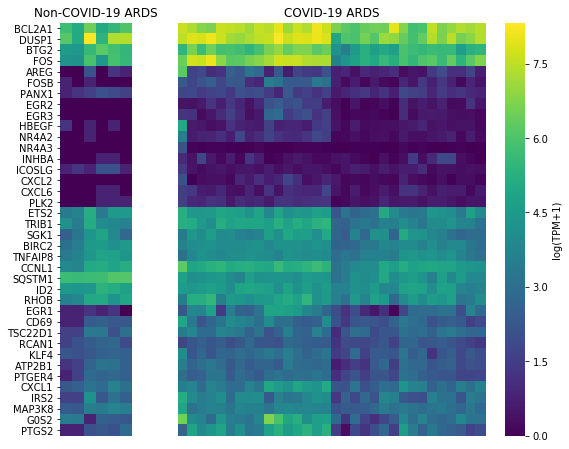

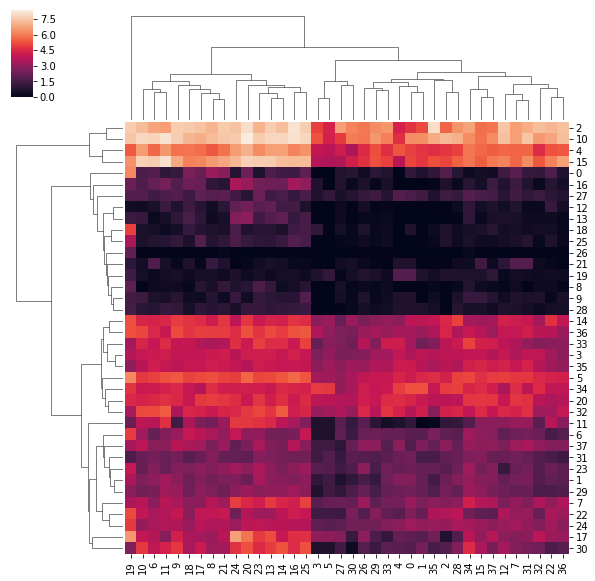

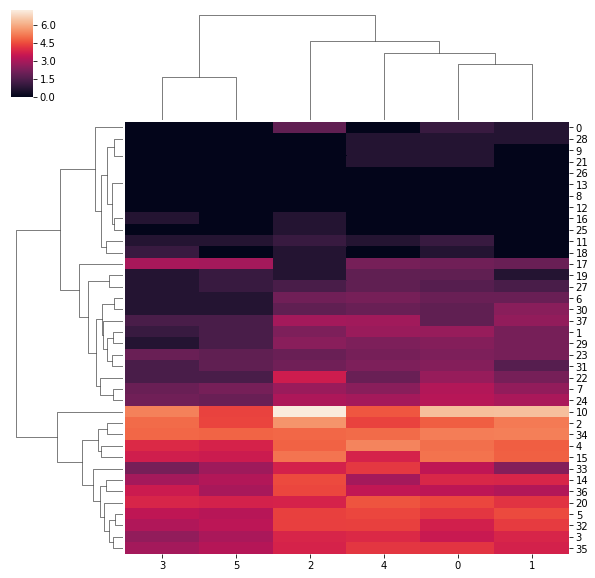

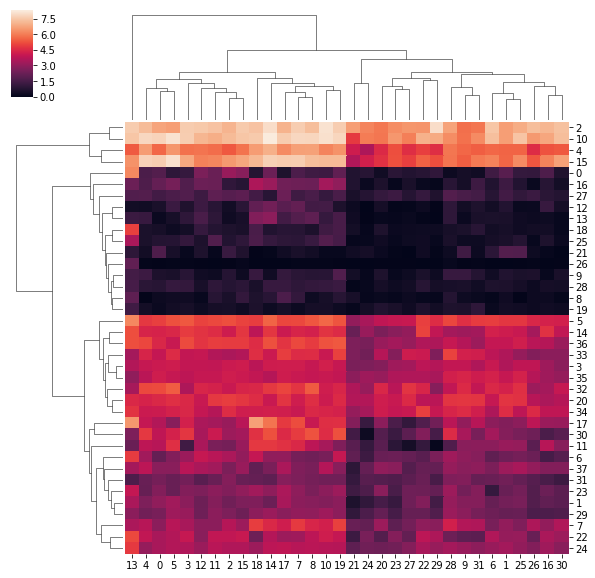

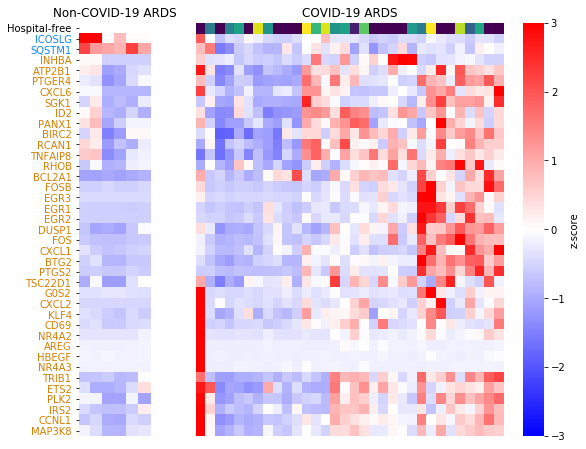

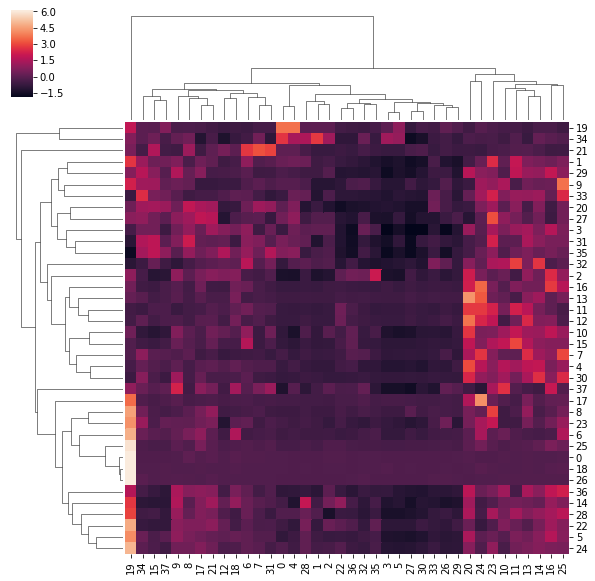

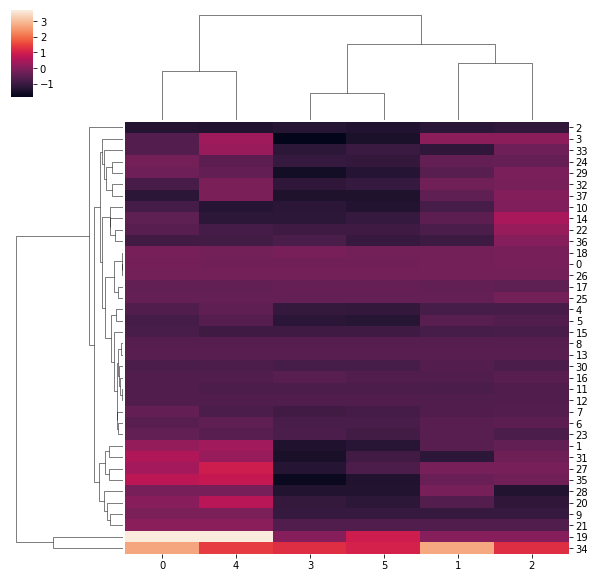

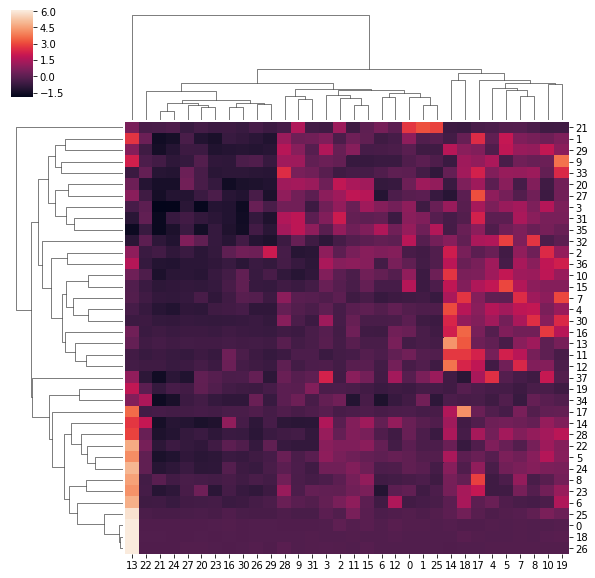

In [14]:
import heatmap_from_de as hfd

up_ec_f = join(RAW_DATA_LOC, 'Albany_and_Englert/ebseq_males.ARDS.COVID.v.NO_HSCT/Up.Genes.pp99.Normed.tsv')
down_ec_f = join(RAW_DATA_LOC, 'Albany_and_Englert/ebseq_males.ARDS.COVID.v.NO_HSCT/Down.Genes.pp99.Normed.tsv')
albany_meta_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/DCD_v3.tsv')
englert_meta_f  = join(RAW_DATA_LOC, 'englert_meta.tsv')
albany_expr_f = join(RAW_DATA_LOC, 'AHNMJYDMXX_rsem/genes.tpm.no_hg.no_C054.tab')
englert_expr_f = join(RAW_DATA_LOC, 'ARDS/g.tpm.tab')
out_f = join(OUT_LOC, 'englert_vs_albany_de/filter_DE_AE_11/male_only_heatmaps')

for gene_set in df['gene_set']:
    hfd.plot_heatmap(
        'gene_sets',
        gene_set,
        up_ec_f,
        down_ec_f,
        albany_meta_f,
        englert_meta_f,
        albany_expr_f,
        englert_expr_f,
        out_f,
        male_only=True
    )